In [1]:
name = None
work_path = r"C:\Ariel codes\networks\final project\Networks_Final_Project\resources"
my_country="IL"

In [2]:
# importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
import requests

In [3]:
#time delays between 2 consecutive messages
def add_delays(df: pd.DataFrame):
    df["Time_delay"] = (df["Time"].diff().fillna(0)).round(6)

#packets length diffs 2 consecutive messages
def add_lengths(df: pd.DataFrame):
    df["Length_diff"] = abs(df["Length"].diff()).fillna(0)


def reformat_columns(df: pd.DataFrame):
    df["No."] = df["No."].astype(float)
    df["Time"] = df["Time"].astype(float)
    df["Length"] = df["Length"].astype(float)

In [4]:
def load_csv(number):
    if number == '1':
        name = "whatsappMessagesCSV"
        path = work_path + "/RAW/CSV/" + name + ".csv"
        print("---------Mixed Group (Mostly Messages)----------")
    elif number == '2':
        name = "whatsappImagesCSV"
        path = work_path + "/RAW/CSV/" + name + ".csv"
        print("---------Images----------")
    elif number == '3':
        name = "whatsappAudioCSV"
        path = work_path + "/RAW/CSV/" + name + ".csv"
        print("---------Audio----------")
    elif number == '4':
        name = "whatsappVideosCSV"
        path = work_path + "/RAW/CSV/" + name + ".csv"
        print("---------Videos----------")
    elif number == '5':
        name = "whatsappFilesCSV"
        path = work_path + "/RAW/CSV/" + name + ".csv"
        print("---------Files----------")
    elif number == '6':
        name = "WhatsappNoisedGroupCSV"
        path = work_path + "/RAW/CSV/" + name + ".csv"
        print("---------Group With Noise----------")
    elif number == '7':
        name = "whatsappAtteckedRegularUseCSV"
        path = work_path + "/RAW/CSV/" + name + ".csv"
        print("---------Attacked User Active in multiple groups (usual activity)----------")
    elif number == '8':
        name = "whatsappAtteckedRegularUseCSV"
        path = work_path + "/RAW/CSV/" + name + ".csv"
        print("--------- Attacker when Attacked User Active in multiple groups (usual activity)----------")
    
    df = pd.read_csv(path, sep=',', header=0,
                     usecols=["No.", "Time", "Source", "Destination", "Protocol", "Length", "Info"])
    reformat_columns(df)
    add_delays(df)
    add_lengths(df)
    print(df.head())
    return df, name

In [5]:
def plot_activity_trends(df):
    # Plot the message count over time using a line chart
    plt.figure(figsize=(15, 4))
    plt.plot(df["Time"], df["Length"], marker='o', linestyle='-')
    plt.xlabel("Time")
    plt.ylabel("Length")
    plt.title("Message Count and Activity Trends")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [6]:
def rows_of_probably_noisy_packets(df):
    df_copy = df.copy()  # Explicitly make a copy of the dataframe

    # Extract the first number from the "Source" column
    df_copy["FirstNumber"] = df_copy["Source"].str.split('.').str[0]

    median_lengths = df_copy.groupby('FirstNumber')['Length'].median()

    # Filter the 'FirstNumber' values where the median is greater than 500
    desired_nums = median_lengths[median_lengths > 500].index.tolist()
    
    wanted_ips = set()
    unwanted_ips = set()
    
    for index, row in df_copy.iterrows():
        if row['FirstNumber'] in desired_nums and not (row['Source'] in wanted_ips or row['Source'] in unwanted_ips):
            url = f"https://freeipapi.com/api/json/{row['Source']}"
            response = requests.get(url)
            data = response.json()
            country = data['countryCode']
            if country == my_country:
                wanted_ips.add(row['Source'])
            else:
                unwanted_ips.add(row['Source'])
            sleep(0.02)

    rows_of_interest_src = df_copy[df_copy['Source'].isin(wanted_ips) | df_copy['Source'].str.startswith(('157', '10'))].index.tolist()
    
    rows_of_interest_dst = df_copy[df_copy['Destination'].isin(wanted_ips) | df_copy['Destination'].str.startswith(('157', '10'))].index.tolist()
    
    row_numbers = list(set(rows_of_interest_dst) & set(rows_of_interest_src))

    return row_numbers

In [7]:
#bar plot of length packetlength changes in time
def bar_plot(df):
    plt.figure(figsize=(9, 4))
    plt.bar(df["Time"], df["Length"])
    plt.xlabel("Time")
    plt.ylabel("Length")
    plt.title("Bar Chart of Length vs Time")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [8]:
#counting the sizes of packets (num of packets in a certain ranges) 
def count_length_ranges(df: pd.DataFrame):
    ranges = {
        "0-50": (0, 50),
        "51-100": (51, 100),
        "100-500": (101, 500),
        "501-1000": (501, 1000),
        "1001-1500": (1001, 1500),
        ">1500": (1501, float("inf"))
    }
    
    range_counts = {range_name: 0 for range_name in ranges}
    
    for range_name, (lower, upper) in ranges.items():
        range_counts[range_name] = ((df["Length"] >= lower) & (df["Length"] <= upper)).sum()
    
    return range_counts

In [9]:
def plot_length_range_counts(length_range_counts):
    range_names = list(length_range_counts.keys())
    counts = list(length_range_counts.values())
    
    plt.figure(figsize=(5, 4))
    plt.bar(range_names, counts)
    plt.xlabel("Length Range")
    plt.ylabel("Count")
    plt.title("Count of Cells in Each Length Range")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [10]:
#plot of packet length with the frequency of this packet length
def plot_length_histogram(df: pd.DataFrame):
    plt.figure(figsize=(10, 6))
    plt.hist(df["Length"], bins=df["Length"].nunique(), edgecolor="black")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    plt.title("Length Histogram")
    plt.show()

In [11]:
def remove_middle_row(df: pd.DataFrame, threshold: int = 500, lendth_diff: int = 20):
    # Reset the index to ensure a continuous integer index
    df = df.reset_index(drop=True)
    
    rows_to_remove = []

    for i in range(1, len(df) - 1):
        # Using .iloc for positional indexing
        length_diff = abs(df.iloc[i - 1]["Length"] - df.iloc[i + 1]["Length"])
        
        first_condition = (length_diff <= lendth_diff) and \
                          (df.iloc[i - 1]["Length"] > threshold) and \
                          (df.iloc[i + 1]["Length"] > threshold)
        
        second_condition = (df.iloc[i - 1]["Length"] > threshold) and \
                           (df.iloc[i + 1]["Length"] > threshold) and \
                           (df.iloc[i]["Length"] < threshold)
        
        if (first_condition or second_condition):
            rows_to_remove.append(i)

    cleaned_df = df.drop(rows_to_remove)
    cleaned_df.reset_index(drop=True, inplace=True)
    
    return cleaned_df


Please select which Whatsapp Group you want to clean:
1 - Mixed messages (a bit from everything)
2 - Mostly Images
3 - Mostly Audio
4 - Mostly videos
5 - Mostly Files
6 - Noisy recording
7 - Attacked user active in several groups
8 - Attacker when Attacked user active in several groups
9 - Exit
8
--------- Attacker when Attacked User Active in multiple groups (usual activity)----------
   No.      Time          Source     Destination Protocol  Length  \
0  1.0  0.000000  157.240.214.60       10.0.2.15  TLSv1.2   131.0   
1  2.0  0.053742       10.0.2.15  157.240.214.60      TCP    54.0   
2  3.0  0.366729       10.0.2.15   34.104.35.123      TCP    54.0   
3  4.0  0.367373   34.104.35.123       10.0.2.15      TCP    60.0   
4  5.0  1.595100   172.217.22.46       10.0.2.15  TLSv1.2   127.0   

                                                Info  Time_delay  Length_diff  
0                                   Application Data    0.000000          0.0  
1   40198  >  443 [ACK] Seq=1 Ack=78

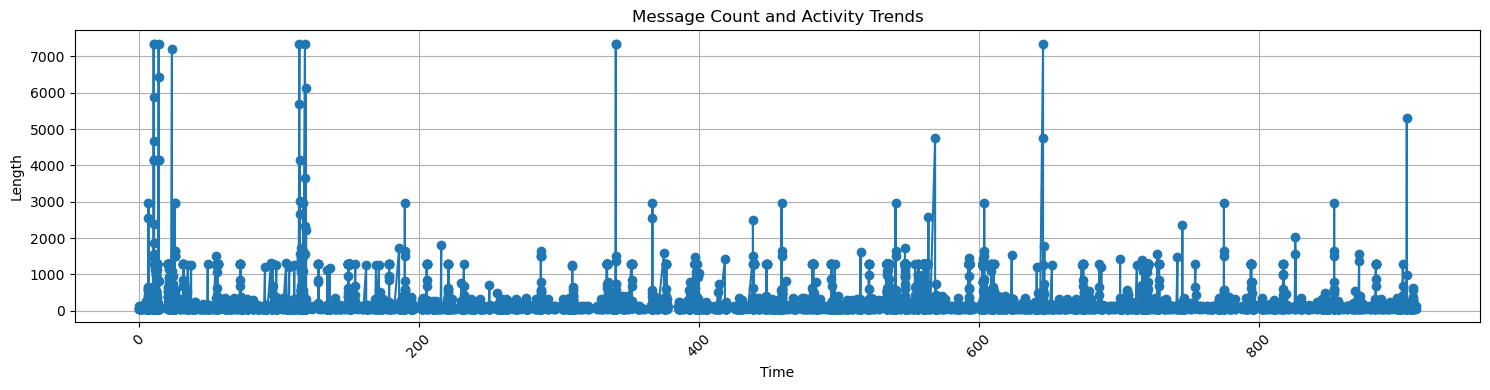

In [12]:
invalid = True
while invalid:
    answer = input("Please select which Whatsapp Group you want to clean:\n"
                           "1 - Mixed messages (a bit from everything)\n"
                           "2 - Mostly Images\n"
                           "3 - Mostly Audio\n"
                           "4 - Mostly videos\n"
                           "5 - Mostly Files\n"
                           "6 - Noisy recording\n"
                           "7 - Attacked user active in several groups\n"
                           "8 - Attacker when Attacked user active in several groups\n"
                           "9 - Exit\n")
    if answer != '1' and answer != '2' and answer != '3' and answer != '4' and answer != '5' and answer != '6' and answer != '7' and answer != '8' and answer != '9':
        print("Invalid value. Please enter a valid number\n")
    elif answer == '9':
        invalid = False
        print("Goodbye")
    else:
        invalid = False
        df, name = load_csv(answer)
        plot_activity_trends(df)

In [13]:
df

,No.,Time,Source,Destination,Protocol,Length,Info,Time_delay,Length_diff
0,1.0,0.000000,157.240.214.60,10.0.2.15,TLSv1.2,131.0,Application Data,0.000000,0.0
1,2.0,0.053742,10.0.2.15,157.240.214.60,TCP,54.0,40198 > 443 [ACK] Seq=1 Ack=78 Win=65535 Len=0,0.053742,77.0
2,3.0,0.366729,10.0.2.15,34.104.35.123,TCP,54.0,35596 > 80 [ACK] Seq=1 Ack=1 Win=62780 Len=0,0.312987,0.0
3,4.0,0.367373,34.104.35.123,10.0.2.15,TCP,60.0,[TCP ACKed unseen segment] 80 > 35596 [ACK] ...,0.000643,6.0
4,5.0,1.595100,172.217.22.46,10.0.2.15,TLSv1.2,127.0,Application Data,1.227727,67.0
...,...,...,...,...,...,...,...,...,...
12398,12399.0,910.831507,157.240.214.60,10.0.2.15,TCP,60.0,443 > 40198 [ACK] Seq=227072 Ack=236066 Win=...,0.000393,90.0
12399,12400.0,910.884913,10.0.2.15,157.240.214.60,TLSv1.2,150.0,Application Data,0.053406,90.0
12400,12401.0,910.889031,157.240.214.60,10.0.2.15,TCP,60.0,443 > 40198 [ACK] Seq=227072 Ack=236162 Win=...,0.004118,90.0
12401,12402.0,912.541545,157.240.214.60,10.0.2.15,TLSv1.2,131.0,Application Data,1.652514,71.0


In [14]:
'''protocols that appeared in some recordings, but are not containing messages content:
Elasticsearch: Not a communication protocol but rather a search engine. Elasticsearch operates over HTTP, so the packets might be associated with search queries or indexing operations.
DNS: Domain Name System, used for domain name resolution. its packets doesn't contain message content
SSDP: Simple Service Discovery Protocol, primarily used with UPnP (Universal Plug and Play). It's not related to WhatsApp messages.
HTTP: The foundation of any data exchange on the Web. WhatsApp might use HTTP for certain services, but not likely for message transmission as it would be less secure.
NTP: Network Time Protocol. It's used to synchronize the clocks of computer systems over packet-switched, variable-latency data networks. This would not contain WhatsApp message content.
MDNS: Multicast DNS. Used for resolving hostnames to IP addresses within small networks that do not include a local name server. Not related to WhatsApp message content.
ICMPv6: It's used for diagnostic purposes, error reporting, and other operations related to the management of IP networks.wouldn't contain the content of WhatsApp messages.
NBNS: protocol used on IP networks like the Internet to provide name resolution for NetBIOS over TCP/IP. Thus, doesn't contains data packets.
Thus, we will filter out the rows wherethe protocol is one of the listed above'''

# List of protocols to exclude
protocols_to_exclude = ['Elasticsearch', 'DNS', 'SSDP', 'HTTP', 'NTP', 'MDNS', 'ICMPv6', 'NBNS']

# Filter rows
df = df[~df['Protocol'].isin(protocols_to_exclude)]

In [15]:
protocol_counts = df['Protocol'].value_counts()
print(protocol_counts)

QUIC       7671
TCP        2376
TLSv1.2    2014
TLSv1.3      83
Name: Protocol, dtype: int64


In [16]:
# Create a true copy of df
temp_df = df.copy()

# Extract the first number from the "Source" column
temp_df["FirstNumber"] = temp_df["Source"].str.split('.').str[0]

# Group by both FirstNumber, average packet length, and most used protocol
result_df = temp_df.groupby(["FirstNumber"]).agg(
    Count=('Source', 'size'),
    MedianPacketLength=('Length', 'median'),
    MostUsedProtocol=('Protocol', lambda x: x.mode()[0] if not x.mode().empty else None)  # Use mode to find the most frequent protocol
).reset_index()

result = result_df.groupby("FirstNumber").agg(
    TotalCount=('Count', 'sum'),
    OverallMedianPacketLength=('MedianPacketLength', 'median'),
    OverallMostUsedProtocol=('MostUsedProtocol', lambda x: x.mode()[0] if not x.mode().empty else None)
).reset_index()

result = result.sort_values(by='TotalCount', ascending=False).reset_index(drop=True)

print(result)

   FirstNumber  TotalCount  OverallMedianPacketLength OverallMostUsedProtocol
0           10        4885                       80.0                    QUIC
1          213        4405                     1274.0                    QUIC
2          157        2272                      126.0                     TCP
3          172         201                       76.0                    QUIC
4           34         108                       60.0                     TCP
5           13          65                       60.0                     TCP
6           54          53                       60.0                     TCP
7            3          46                       60.0                     TCP
8           44          36                       60.0                     TCP
9           35          35                       60.0                     TCP
10         142          22                       60.0                     TCP
11          91           8                       60.0           

In [17]:
df = df.loc[rows_of_probably_noisy_packets(df)]

In [18]:
df = df[df["Length"]<10000] #probably an error packet, median size of big packets is about 1200
df = df[~(df['Info'].str.contains('Len=0', case=False, na=False))]

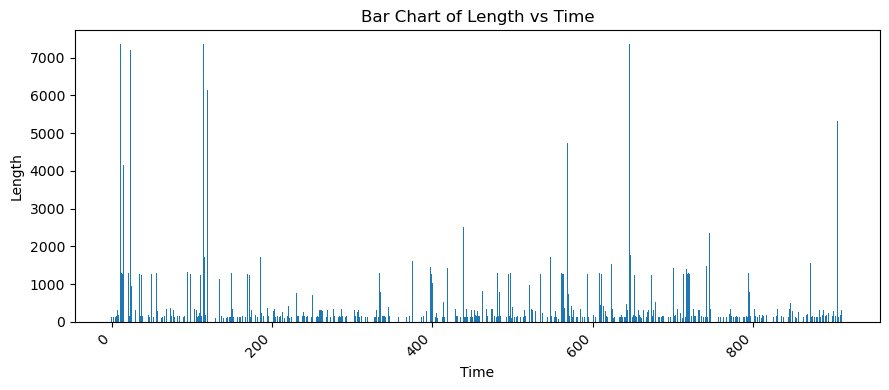

In [19]:
bar_plot(df)

In [20]:
grouped_df = df.groupby('Info').size().reset_index(name='Count')
sorted_df = grouped_df.sort_values(by='Count', ascending=False).reset_index(drop=True)

set(sorted_df['Info'].tolist())

{'0-RTT, DCID=0942b14a9e2ec293',
 '0-RTT, DCID=101c3d94a96fe8b6',
 '0-RTT, DCID=12e29a07e2f9b37b',
 '0-RTT, DCID=1db8eb8bee41d60b',
 '0-RTT, DCID=1e2fed11d926b414',
 '0-RTT, DCID=2207d0f375f2d58c',
 '0-RTT, DCID=2addd2ab8e9b84eb',
 '0-RTT, DCID=38fb3e8e5523089e',
 '0-RTT, DCID=3aae37ca43624769',
 '0-RTT, DCID=3fd56362171838f8',
 '0-RTT, DCID=59fd5c828ed9c668',
 '0-RTT, DCID=60cd1c91b6ed1eba',
 '0-RTT, DCID=671ea1aa45d41fac',
 '0-RTT, DCID=8c4d1caa6acbdc55',
 '0-RTT, DCID=917402128ea60686',
 '0-RTT, DCID=919a305022becefe',
 '0-RTT, DCID=9b0baaca80b7c68d',
 '0-RTT, DCID=a0a3f86d5ed7d318',
 '0-RTT, DCID=a429ba5872ab2fc3',
 '0-RTT, DCID=ac615be6f859e4fe',
 '0-RTT, DCID=ca10f5d9ef6d8f4f',
 '0-RTT, DCID=fe01472d3cdb73d8',
 '40198  >  443 [PSH, ACK] Seq=133021 Ack=113896 Win=65535 Len=7300 [TCP segment of a reassembled PDU]',
 '40198  >  443 [PSH, ACK] Seq=140321 Ack=113896 Win=65535 Len=7300 [TCP segment of a reassembled PDU]',
 '40198  >  443 [PSH, ACK] Seq=188857 Ack=175643 Win=65535 Len=7

In [21]:
df = df[~df['Info'].str.contains('Initial', case=False, na=False)]
df = df[~(df['Info'].str.contains('Change Cipher Spec', case=False, na=False) & (df['Length'] <= 250))]
df = df[~(df['Info'].str.lower() == 'client hello')]
df = df[~(df['Info'].str.contains('Server Hello', case=False, na=False) & (df['Length'] <= 250))]
cleaned_df = remove_middle_row(df)

In [22]:
df.head(20)

,No.,Time,Source,Destination,Protocol,Length,Info,Time_delay,Length_diff
0,1.0,0.000000,157.240.214.60,10.0.2.15,TLSv1.2,131.0,Application Data,0.000000,0.0
9,10.0,1.925049,157.240.214.60,10.0.2.15,TLSv1.2,131.0,Application Data,0.315621,77.0
13,14.0,2.990030,157.240.214.60,10.0.2.15,TLSv1.2,131.0,Application Data,0.577013,71.0
15,16.0,4.436224,10.0.2.15,157.240.214.60,TLSv1.2,124.0,Application Data,1.446155,70.0
17,18.0,5.385900,10.0.2.15,157.240.214.60,TLSv1.2,124.0,Application Data,0.949213,64.0
19,20.0,5.553340,10.0.2.15,157.240.214.60,TLSv1.2,270.0,Application Data,0.166681,210.0
21,22.0,5.570427,157.240.214.60,10.0.2.15,TLSv1.2,126.0,Application Data,0.016399,66.0
23,24.0,5.798262,157.240.214.60,10.0.2.15,TLSv1.2,165.0,Application Data,0.227813,111.0
25,26.0,6.143984,157.240.214.60,10.0.2.15,TLSv1.2,150.0,Application Data,0.345689,96.0
27,28.0,6.147269,10.0.2.15,157.240.214.60,TLSv1.2,149.0,Application Data,0.003269,95.0


In [23]:
df.drop(columns=["Time_delay","Length_diff"], inplace=True)
df.to_csv(work_path + "/CLEAN/" + name + 'Clean.csv', index=False)